In [1]:
%matplotlib inline
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb
import metric, motif
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True

In [2]:
# Parameters
window_size = 128
radiuses = np.linspace(0.1, 10.0, 100)
max_motifs = 16
mode = 'right'  # left/center/right

In [3]:
# Load time series
signals, fields = wfdb.rdsamp('../mitdb/106')
X = signals[:, 0].reshape((-1, 1))

# Load annotation
ann = wfdb.rdann('../mitdb/106', 'atr')
df = pd.DataFrame({'annotation': ann.symbol}, index=ann.sample)

# Get indices of normal heartbeats (N) and PVCs (V)
indices0 = np.array(df.index[df['annotation'] == 'N'])
indices1 = np.array(df.index[df['annotation'] == 'V'])

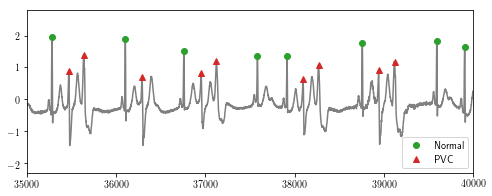

In [4]:
# Visualize annotation on time series
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(X, c='0.5')
ax.plot(indices0, X[indices0], 'o', c='tab:green', label='Normal')
ax.plot(indices1, X[indices1], '^', c='tab:red', label='PVC')
ax.set_xlim(35000, 40000)
plt.legend()
plt.savefig('../figures/ecg_annotation.pdf', bbox_inches='tight')

In [5]:
# # Shorten the time series to check the algorithhm simply
# begin = 30000
# end = 50000  # 40000
# X = X[begin:end]
# indices0 = indices0 - begin
# indices0 = indices0[indices0 >= 0]
# indices0 = indices0[indices0 < end - begin - window_size]
# indices1 = indices1 - begin
# indices1 = indices1[indices1 >= 0]
# indices1 = indices1[indices1 < end - begin - window_size]

In [6]:
# ScanMK
mk = motif.ScanMK()
mk.prepare([X], window_size)
%time mk.scan()
with open('mitdb106_mk.pkl', mode='wb') as f:
    pickle.dump(mk, f)

ScanMK: 100%|███████████████████████████████████████████████████████████████████| 19873/19873 [00:39<00:00, 498.69it/s]


Wall time: 39.9 s


In [7]:
# SetFinder
sf = motif.SetFinder()
sf.prepare([X], window_size)
%time sf.count(radiuses)
with open('mitdb106_sf.pkl', mode='wb') as f:
    pickle.dump(sf, f)

SetFinder: 100%|████████████████████████████████████████████████████████████████| 19873/19873 [01:35<00:00, 209.04it/s]


Wall time: 1min 35s


In [8]:
# HubFinder
hf = motif.HubFinder()
%time hf.compute([X], window_size, max_motifs)
print(hf.motifs)
with open('mitdb106_hf.pkl', mode='wb') as f:
    pickle.dump(hf, f)

HubFinder: 100%|████████████████████████████████████████████████████████████████| 19873/19873 [00:30<00:00, 662.29it/s]


Wall time: 33.4 s
[14523, 5977, 8239, 4874, 10460, 18202, 14176, 13358, 3510, 16964, 2543, 15228, 17902, 18543, 0, 17392]


In [9]:
# Load computed results
with open('mitdb106_mk.pkl', mode='rb') as f:
   mk = pickle.load(f)
with open('mitdb106_sf.pkl', mode='rb') as f:
   sf = pickle.load(f)
with open('mitdb106_hf.pkl', mode='rb') as f:
   hf = pickle.load(f)

In [10]:
# Correct annotation
if mode == 'center':
    offset = window_size // 2
elif mode == 'right':
    offset = window_size
else:
    offset = 0
length = hf.mp.sum_lengths
indices0 -= offset
indices1 -= offset
indices0 = indices0[(0 <= indices0) & (indices0 <= length - window_size + offset)]
indices1 = indices1[(0 <= indices1) & (indices1 <= length - window_size + offset)]
indices = np.concatenate([indices0, indices1])

# Extract subsequences according to annotation
X0 = hf.mp.get_subsequences(indices0)
X1 = hf.mp.get_subsequences(indices1)
X0 = np.array(X0).reshape([-1, window_size])
X1 = np.array(X1).reshape([-1, window_size])

# Standardize and condcatenate the extracted subsequences
X0std = (X0 - X0.mean(axis=1, keepdims=True)) / X0.std(axis=1, keepdims=True)
X1std = (X1 - X1.mean(axis=1, keepdims=True)) / X1.std(axis=1, keepdims=True)
Xstd = np.concatenate([X0std, X1std], axis=0)

# Get ground truth
actuals0 = np.full(len(indices0), 0)
actuals1 = np.full(len(indices1), 1)
actuals = np.concatenate([actuals0, actuals1])

Wall time: 158 ms


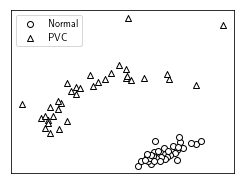

In [11]:
# Visualize MDS of extracted subsequences
mds = motif.MultiDimensionalScaling()
%time mds.fit(Xstd, actuals)
mds.plot(width=4, height=3, labels={0: 'Normal', 1: 'PVC'}, filename='../figures/ecg_mds.pdf')

In [12]:
# Compute purity of ScanMK
mk_purities = {}
for radius in radiuses:
    print('\nradius =', radius)
    %time mk.find(radius)
    print(mk.motifs)
    if len(mk.motifs) > 0:
        # Visualize MDS
#         predictions = mk.get_nearest_labels(indices, bound=window_size)
#         mds.plot(predictions, width=4, height=3,
#                  title='ScanMK (radius = {:g})'.format(radius),
#                  filename='../figures/ecg_mds_mk_{:.1f}.pdf'.format(radius))
        # Compute purity
        purities = [np.nan]
        for num_motifs in range(1, len(mk.motifs) + 1):
            predictions = mk.get_nearest_labels(indices, num_motifs, bound=window_size)
            purity = motif.get_purity(actuals, predictions)
            purities.append(purity)
        mk_purities[radius] = purities


radius = 0.1
Wall time: 2 ms
[]

radius = 0.2
Wall time: 1 ms
[]

radius = 0.3
Wall time: 1 ms
[]

radius = 0.4
Wall time: 984 µs
[]

radius = 0.5
Wall time: 0 ns
[]

radius = 0.6
Wall time: 27.9 ms
[10244, 3667, 8239, 19332]

radius = 0.7
Wall time: 68.8 ms
[10244, 3667, 8239, 19332, 16267, 14852, 7103, 12779, 3809, 4953, 5156, 6402]

radius = 0.8
Wall time: 121 ms
[10244, 3667, 8239, 19332, 5581, 14852, 9106, 4953, 5156, 6402, 11232, 14702, 18543, 13476, 6636, 9041, 5479, 3351]

radius = 0.9
Wall time: 253 ms
[10244, 3667, 19332, 5581, 14852, 4953, 5156, 6402, 6962, 18543, 10097, 13477, 6636, 14523, 7593, 5277, 17316, 6316, 17760, 11711, 15228, 18202, 12615, 6770, 11012, 11314]

radius = 1.0
Wall time: 286 ms
[10244, 3667, 19332, 5581, 4953, 5156, 6962, 13477, 6636, 14523, 7593, 5277, 17316, 17760, 11711, 18202, 12615, 10179, 6770, 11012, 3849, 14384, 1433, 7169, 6852, 2874, 8952, 5686, 16201, 2212, 3417, 14104, 19227, 892, 2013, 3018, 2657, 19833]

radius = 1.1
Wall time: 337 ms
[1

radius = 4.8
Wall time: 56.8 ms
[10244, 3667, 5156, 16242, 5277, 6852, 15617, 8356, 16845, 693, 10422, 15506]

radius = 4.9
Wall time: 54.8 ms
[10244, 3667, 5156, 5556, 5277, 6852, 15617, 8357, 16845, 10409, 88, 15506]

radius = 5.0
Wall time: 51.9 ms
[10244, 3667, 5156, 5556, 5277, 6852, 15616, 5724, 16845, 10409, 15506]

radius = 5.1
Wall time: 63.6 ms
[10244, 3667, 5156, 5277, 19294, 6852, 15616, 8358, 16845, 10409, 15505]

radius = 5.2
Wall time: 60.4 ms
[10244, 3667, 5156, 9899, 19293, 14593, 15614, 5725, 16845, 10409, 15504]

radius = 5.3
Wall time: 51.9 ms
[10244, 3667, 5156, 9899, 19293, 14593, 15614, 8359, 16845, 10409, 15503]

radius = 5.4
Wall time: 51.9 ms
[10244, 3667, 5156, 9899, 19293, 14593, 15614, 16845, 5726, 10409, 15503]

radius = 5.5
Wall time: 54.9 ms
[10244, 3667, 5156, 9899, 19293, 14592, 4431, 8360, 16897, 10407, 15464]

radius = 5.6
Wall time: 64.8 ms
[10244, 3667, 5156, 9899, 19293, 14592, 4432, 16897, 8361, 11509, 15466]

radius = 5.7
Wall time: 70.8 ms
[102

In [13]:
# Compute purity of SetFinder
sf_purities = {}
for radius in radiuses:
    print('\nradius =', radius)
    %time sf.find(radius)
    print(sf.motifs)
    if len(sf.motifs) > 0:
        # Visualize MDS
#         predictions = sf.get_nearest_labels(indices, bound=window_size)
#         mds.plot(predictions, width=4, height=3,
#                  title='SetFinder (radius = {:g})'.format(radius),
#                  filename='../figures/ecg_mds_sf_{:.1f}.pdf'.format(radius))
        # Compute purity
        purities = [np.nan]
        for num_motifs in range(1, len(sf.motifs) + 1):
            predictions = sf.get_nearest_labels(indices, num_motifs, bound=window_size)
            purity = motif.get_purity(actuals, predictions)
            purities.append(purity)
        sf_purities[radius] = purities


radius = 0.1
Wall time: 998 µs
[]

radius = 0.2
Wall time: 996 µs
[]

radius = 0.3
Wall time: 996 µs
[]

radius = 0.4
Wall time: 998 µs
[]

radius = 0.5
Wall time: 1 ms
[]

radius = 0.6
Wall time: 16 ms
[3666, 8223, 10224, 11376]

radius = 0.7
Wall time: 31.9 ms
[8247, 3668, 16313, 19336, 3805, 4952, 5156, 5557, 6402, 12779]

radius = 0.8
Wall time: 39.9 ms
[8243, 16314, 4874, 19326, 4956, 5155, 10096, 18536, 5547, 5632, 6635, 6959, 13476]

radius = 0.9
Wall time: 47.9 ms
[12784, 11241, 3666, 7100, 19330, 4954, 18535, 6113, 3352, 6632, 2210, 5275, 6958, 11001, 11312, 11710, 12612, 17296, 18198]

radius = 1.0
Wall time: 68.8 ms
[14856, 11240, 19335, 4956, 6118, 6633, 3351, 3876, 6962, 12636, 2543, 5556, 10999, 17626, 17753, 18195, 1433, 2012, 2657, 2872, 3015, 3416, 4318, 5271, 6846, 11709, 13273, 13545, 13783]

radius = 1.1
Wall time: 85.8 ms
[11241, 14862, 19329, 14172, 6113, 6967, 11712, 3882, 6634, 2876, 3350, 5550, 9872, 869, 2013, 2353, 6699, 6854, 8667, 10170, 10994, 14102, 1615

Wall time: 18.9 ms
[9606, 7728, 5939, 6866, 17357, 9249, 15463]

radius = 6.5
Wall time: 19.9 ms
[9607, 7725, 6593, 6870, 10975, 790, 15463]

radius = 6.6
Wall time: 19.9 ms
[9606, 7726, 6592, 6873, 10977, 790, 15481]

radius = 6.7
Wall time: 21.9 ms
[9608, 7726, 6593, 6875, 17359, 790]

radius = 6.8
Wall time: 15 ms
[14093, 7728, 5941, 6878, 17358]

radius = 6.9
Wall time: 14 ms
[14093, 7725, 5941, 17358, 2772]

radius = 7.0
Wall time: 14 ms
[14094, 7726, 5941, 2772, 17359]

radius = 7.1
Wall time: 12 ms
[14093, 7726, 5120, 2774]

radius = 7.2
Wall time: 16 ms
[14093, 7726, 5120, 2776]

radius = 7.3
Wall time: 14 ms
[14093, 7726, 5121, 2781]

radius = 7.4
Wall time: 13 ms
[14093, 7725, 9431, 2806]

radius = 7.5
Wall time: 13 ms
[14093, 7727, 9432, 2804]

radius = 7.6
Wall time: 11 ms
[14093, 7722, 9430]

radius = 7.7
Wall time: 11 ms
[14093, 7726, 1891]

radius = 7.8
Wall time: 14 ms
[6960, 7723, 794]

radius = 7.9
Wall time: 13 ms
[6961, 7729, 792, 6697]

radius = 8.0
Wall time: 12 m

In [14]:
# Compute purity of HubFinder
hf_purities = [np.nan]
for num_motifs in range(1, len(hf.motifs) + 1):
    print('\nnum_motifs =', num_motifs)
    predictions = hf.get_nearest_labels(indices, num_motifs, bound=window_size)
        # Visualize MDS
#     mds.plot(predictions, width=4, height=3,
#              title='HubFinder (\# motifs = {:g})'.format(num_motifs),
#              filename='../figures/ecg_mds_hf_{:g}.pdf'.format(num_motifs))
    # Compute purity
    purity = motif.get_purity(actuals, predictions)
    hf_purities.append(purity)


num_motifs = 1

num_motifs = 2

num_motifs = 3

num_motifs = 4

num_motifs = 5

num_motifs = 6

num_motifs = 7

num_motifs = 8

num_motifs = 9

num_motifs = 10

num_motifs = 11

num_motifs = 12

num_motifs = 13

num_motifs = 14

num_motifs = 15

num_motifs = 16


In [15]:
# Get radius vs purity for #motifs=2
result_mk_radiuses = []
result_mk_purities = []
for radius in radiuses:
    try:
        result_mk_purities.append(mk_purities[radius][2])
        result_mk_radiuses.append(radius)
    except KeyError:
        continue
    except IndexError:
        result_mk_purities.append(mk_purities[radius][-1])
        result_mk_radiuses.append(radius)
result_sf_radiuses = []
result_sf_purities = []
for radius in radiuses:
    try:
        result_sf_purities.append(sf_purities[radius][2])
        result_sf_radiuses.append(radius)
    except KeyError:
        continue
    except IndexError:
        result_sf_purities.append(sf_purities[radius][-1])
        result_sf_radiuses.append(radius)

# Get the best radius and purity
argmax = np.array(result_sf_purities).argmax()
sf_best_radius = result_sf_radiuses[argmax]
sf_best_purity = result_sf_purities[argmax]
argmax = np.array(result_mk_purities).argmax()
mk_best_radius = result_mk_radiuses[argmax]
mk_best_purity = result_mk_purities[argmax]
hf_purity = hf_purities[2]
print('purity (num_motifs = 2)')
print('ScanMK: {:g} (@ radius = {:g})'.format(mk_best_purity, mk_best_radius))
print('SetFinder: {:g} (@ radius = {:g})'.format(sf_best_purity, sf_best_radius))
print('HubFinder: {:g}'.format(hf_purity))
mk.find(mk_best_radius)
sf.find(sf_best_radius)

purity (num_motifs = 2)
ScanMK: 0.73913 (@ radius = 7.8)
SetFinder: 0.724638 (@ radius = 6.6)
HubFinder: 1


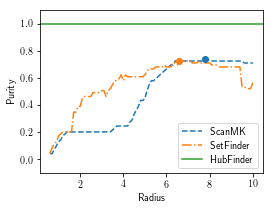

In [16]:
# Visualize radius vs purity
fig, ax = plt.subplots(figsize=(4, 3))
ax.plot(result_mk_radiuses, result_mk_purities, '--', c='tab:blue', label='ScanMK')
ax.plot(result_sf_radiuses, result_sf_purities, '-.', c='tab:orange', label='SetFinder')
ax.plot(mk_best_radius, mk_best_purity, 'o', c='tab:blue')
ax.plot(sf_best_radius, sf_best_purity, 'o', c='tab:orange')
ax.axhline(hf_purity, ls='-', c='tab:green', label='HubFinder')
ax.set_xlabel('Radius')
ax.set_ylabel('Purity')
ax.set_ylim(-0.1, 1.1)
ax.legend()
plt.savefig('../figures/ecg_radius_vs_purity.pdf', bbox_inches='tight', pad_inches=0)

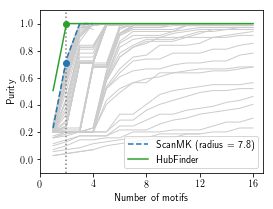

In [17]:
# Visualize #motfs vs purity (ScanMK)
fig, ax = plt.subplots(figsize=(4, 3))
for radius in radiuses:
    try:
        ax.plot(mk_purities[radius][:max_motifs + 1], lw=1, c='0.8')
    except KeyError:
        continue
ax.axvline(2, ls=':', c='0.5')
ax.plot(mk_purities[mk_best_radius], '--', c='tab:blue',
        label='ScanMK (radius = {:g})'.format(mk_best_radius))
ax.plot(hf_purities, '-', c='tab:green', label='HubFinder')
ax.plot(2, sf_purities[mk_best_radius][2], 'o', c='tab:blue')
ax.plot(2, hf_purities[2], 'o', c='tab:green')
ax.set_xlabel('Number of motifs')
ax.set_ylabel('Purity')
ax.set_xticks(range(0, max_motifs + 1, 4))
ax.set_ylim(-0.1, 1.1)
ax.legend()
plt.savefig('../figures/ecg_motif_vs_purity_mk.pdf', bbox_inches='tight', pad_inches=0)

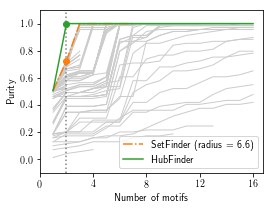

In [18]:
# Visualize #motfs vs purity (SetFinder)
fig, ax = plt.subplots(figsize=(4, 3))
for radius in radiuses:
    try:
        ax.plot(sf_purities[radius][:max_motifs + 1], lw=1, c='0.8')
    except KeyError:
        continue
ax.axvline(2, ls=':', c='0.5')
ax.plot(sf_purities[sf_best_radius], '-.', c='tab:orange',
        label='SetFinder (radius = {:g})'.format(sf_best_radius))
ax.plot(hf_purities, '-', c='tab:green', label='HubFinder')
ax.plot(2, sf_purities[sf_best_radius][2], 'o', c='tab:orange')
ax.plot(2, hf_purities[2], 'o', c='tab:green')
ax.set_xlabel('Number of motifs')
ax.set_ylabel('Purity')
ax.set_xticks(range(0, max_motifs + 1, 4))
ax.set_ylim(-0.1, 1.1)
ax.legend()
plt.savefig('../figures/ecg_motif_vs_purity_sf.pdf', bbox_inches='tight', pad_inches=0)

ScanMotif

1 motif = 10244


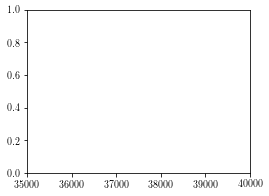


2 motif = 3667


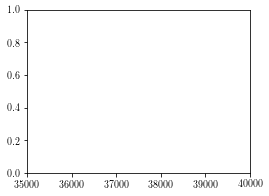

SetFinder

1 motif = 9606


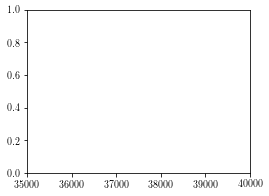


2 motif = 7726


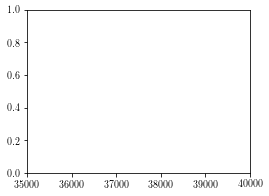

HubFinder

1 motif = 14523


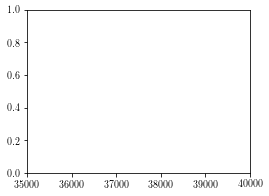


2 motif = 5977


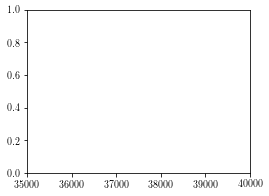

In [19]:
# Visualize motifs
print('ScanMotif')
mk.plot_motifs(2, begin=35000, end=40000)
print('SetFinder')
sf.plot_motifs(2, begin=35000, end=40000)
print('HubFinder')
hf.plot_motifs(2, begin=35000, end=40000)

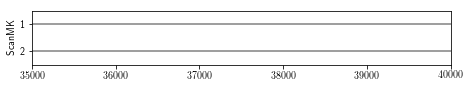

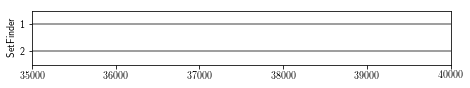

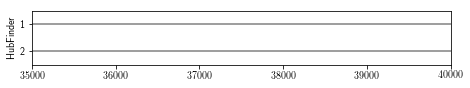

In [20]:
# Visualize motif labels
mk.plot_labels(2, begin=35000, end=40000, xscale=0.0015, yscale=0.5, ylabel='ScanMK', filename='../figures/ecg_mk_motifs.pdf')
sf.plot_labels(2, begin=35000, end=40000, xscale=0.0015, yscale=0.5, ylabel='SetFinder', filename='../figures/ecg_sf_motifs.pdf')
hf.plot_labels(2, begin=35000, end=40000, xscale=0.0015, yscale=0.5, ylabel='HubFinder', filename='../figures/ecg_hf_motifs.pdf')